# モデルの評価とハイパーパラメータのチューニングのベストプラクティス

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

Split sample data into training data and test data

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# 連結する処理としてスケーリング、主成分分析、ロジスティック回帰を指定
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [7]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
# 分割元データ、分割数、乱数生成器の状態を指定し、層化k分割交差検証イテレータを表すStratifiedKFoldクラスのインスタンス化
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores=[]
# イテレータのインデックスと要素をループ処理：（上から順に）
#  データをモデルに適合
#  テストデータの正解率を算出
#  リストに正解率を追加
#  分割の番号、0以上の要素数、正解率を出力
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [8]:
# 正解率の平均と標準偏差を出力
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [9]:
from sklearn.cross_validation import cross_val_score
# 交差検証のcross_val_score関数でモデルの正解率を算出
# 推定器estimator、トレーニングデータX、予測値y、分割数cv、CPU数n_jobsを指定
scores = cross_val_score(estimator=pipe_lr, X=X_train,y=y_train, cv=10, n_jobs=4)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [10]:
print('CV accuracy: %.3f += %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 += 0.029


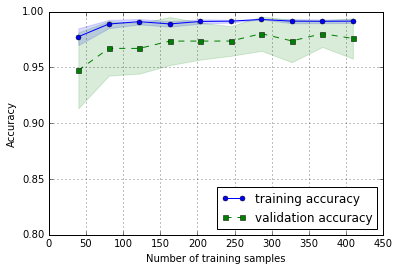

In [11]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(penalty='l2', random_state=0))])
# learnin_curve関数で交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1.0,10), cv=10, n_jobs=4)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,label='training accuracy')
# fill_between関数で平均±標準偏差の幅を塗りつぶす
# トレーニングデータのサイズtrain_sizes、透明度alpha、カラー'blue'を引数に指定
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

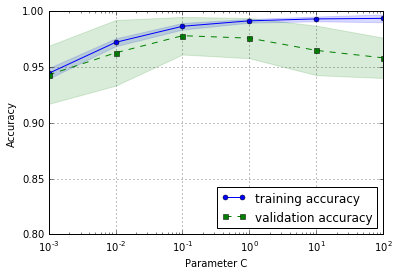

In [12]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# validation_curve関数によりモデルのパラメータを変化させ、交差検証による正解率を算出
# clf__CはLogisticRegressionオブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train,y=y_train,param_name='clf__C',param_range=param_range,cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue',marker='o',markersize=5, label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15, color='blue')
plt.plot(param_range, test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std,test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [13]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'clf__C': param_range, 'clf__kernel': ['linear']},{'clf__C':param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]
# ハイパーパラメータの値リストparam_gridを指定し、グリッドサーチを行うGridSearchCVクラスのインスタンス化
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy',cv=10,n_jobs=4)
gs = gs.fit(X_train, y_train)
# モデルの最良スコアを出力
print(gs.best_score_)

0.978021978022


In [14]:
# 最良スコアとなるパラメータ値を出力
print(gs.best_params_)

{'clf__kernel': 'linear', 'clf__C': 0.1}


In [15]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [16]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy',cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [17]:
from sklearn.tree import DecisionTreeClassifier
# ハイパーパラメータ値として決定木の深さパラメータを指定し、グリッドサーチを行うGridSearchCVクラスをインスタンス化
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}], scoring='accuracy',cv=2)
scores = cross_val_score(gs,X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


In [18]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
# テストと予測のデータから混同行列を生成
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


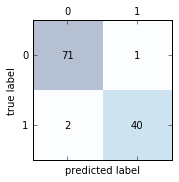

In [20]:
# 図のサイズを指定
fig, ax = plt.subplots(figsize=(2.5,2.5))
# matshow関数で行列からヒートマップを描画
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]): # クラス０の繰り返し処理
    for j in range(confmat.shape[1]): # クラス１の繰り返し処理
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center') # 件数の表示

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [21]:
# 適合率、再現率、F1スコアを出力
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [22]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [23]:
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [24]:
# カスタムの性能指標を出力
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)

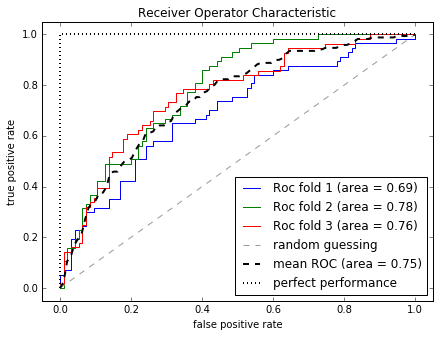

In [31]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
# スケーリング、主成分分析、ロジスティック回帰を指定して、Pipelineクラスをインスタンス化
pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('pca', PCA(n_components=2)), 
                    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])
# ２つの特徴量を抽出
X_train2 = X_train[:, [4,14]]
# 層化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
# 0から1までの間で100個の要素を生成
mean_fpr = np.linspace(0,1,100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    # predict_probaメソッドで確率を予測、fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    # roc_curve関数でROC曲線の性能を計算してプロット
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr) # FPR(X軸)とTPR(y軸)を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) # 曲線下面積(AUC)を計算
    plt.plot(fpr, tpr, lw=1, label='Roc fold %d (area = %0.2f)' % (i+1, roc_auc))

# 当て推量をプロット
plt.plot([0,1],[0,1], linestyle='--', color=(0.6,0.6,0.6), label='random guessing')
# FPR, TPR, ROC, AUCそれぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
# 完全に予測が正解した時のROC曲線をプロット
plt.plot([0,0,1],[0,1,1],lw=2, linestyle=':',color='black',label='perfect performance')
# グラフの各項目を指定
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
# 予測値のAUCと正解率を計算して出力
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4,14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))

ROC AUC: 0.662


In [33]:
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

Accuracy: 0.711


In [34]:
pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')